https://openai.com/blog/gpt-2-1-5b-release/    information about model 

## GPT-2

If you're retraining a model on new text, you need to download the GPT-2 model first. 

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.

Using the `774M` or `1558M` models is not recommended with short sentences

## Amazon comments generator

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.9MB/s 


In [4]:
import gc
import re
import string
import operator
import nltk
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
import seaborn as sns

from nltk import ngrams
from nltk import sentiment
import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

nltk.download('vader_lexicon')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
!pip install datasets

     |████████████████████████████████| 163kB 5.1MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 60.5MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [6]:
from datasets import load_dataset
dataset = load_dataset("amazon_polarity")

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/35b3f5f426863b55dda2d5dc0da2d3714c7b0e5ba64bc4f1415ac9291ffdb234. Subsequent calls will reuse this data.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [8]:
df_train = pd.DataFrame(dataset['train']['content'], columns=['content'])

In [9]:
df_train.head(10)

,content
0,This sound track was beautiful! It paints the ...
1,I'm reading a lot of reviews saying that this ...
2,This soundtrack is my favorite music of all ti...
3,I truly like this soundtrack and I enjoy video...
4,"If you've played the game, you know how divine..."
5,I am quite sure any of you actually taking the...
6,"This is a self-published book, and if you want..."
7,I loved Whisper of the wicked saints. The stor...
8,I just finished reading Whisper of the Wicked ...
9,This was a easy to read book that made me want...


In [12]:
df_train.loc[7][0]

'I loved Whisper of the wicked saints. The story was amazing and I was pleasantly surprised at the changes in the book. I am not normaly someone who is into romance novels, but the world was raving about this book and so I bought it. I loved it !! This is a brilliant story because it is so true. This book was so wonderful that I have told all of my friends to read it. It is not a typical romance, it is so much more. Not reading this book is a crime, becuase you are missing out on a heart warming story.'

In [13]:
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))


Training Set Memory Usage = 27.47 MB


In [14]:
df_train = df_train.iloc[:int(len(df_train)/12), :]
df_train.shape

(300000, 1)

In [15]:
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Training Set Memory Usage = 2.29 MB


## Meta features

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [16]:
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
df_train['unique_word_count'] = df_train['content'].apply(lambda x: len(set(str(x).split())))
df_train['stop_word_count'] = df_train['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_train['url_count'] = df_train['content'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_train['mean_word_length'] = df_train['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_train['char_count'] = df_train['content'].apply(lambda x: len(str(x)))
df_train['punctuation_count'] = df_train['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_train['hashtag_count'] = df_train['content'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_train['mention_count'] = df_train['content'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [17]:
df_train.head()

,content,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,This sound track was beautiful! It paints the ...,75,58,37,0,4.266667,394,9,0,0
1,I'm reading a lot of reviews saying that this ...,91,70,49,0,4.175824,470,12,0,0
2,This soundtrack is my favorite music of all ti...,128,100,57,0,4.867188,750,38,0,0
3,I truly like this soundtrack and I enjoy video...,116,85,46,0,5.224138,721,32,0,0
4,"If you've played the game, you know how divine...",77,62,33,0,4.532468,425,20,0,0


In [18]:
df_train.describe()

,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,75.607883,58.482683,37.013947,0.000847,4.478684,413.527127,12.870617,0.008397,0.002413
std,42.685126,28.802895,21.618779,0.030320,0.466651,236.727801,9.283477,0.230520,0.054902
min,5.000000,1.000000,0.000000,0.000000,1.923077,36.000000,0.000000,0.000000,0.000000
25%,40.000000,34.000000,19.000000,0.000000,4.177419,213.000000,6.000000,0.000000,0.000000
50%,67.000000,54.000000,33.000000,0.000000,4.440476,367.000000,11.000000,0.000000,0.000000
75%,106.000000,79.000000,52.000000,0.000000,4.734513,579.000000,18.000000,0.000000,0.000000
max,240.000000,146.000000,205.000000,3.000000,47.800000,1008.000000,292.000000,96.000000,5.000000


# EDA

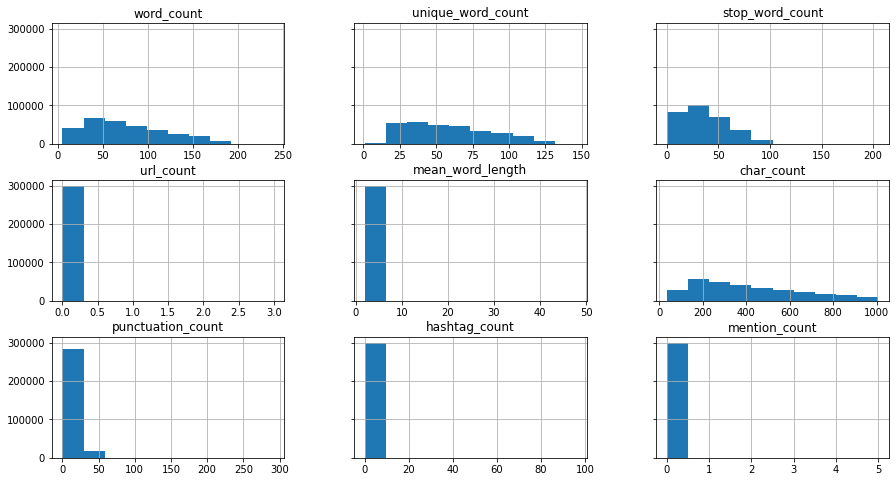

In [19]:
df_train.hist(sharey=True, layout=(3, 3), figsize=(15, 8));

## N-Grams

In [20]:
def get_ngrams_from_series(series, n=2):
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]

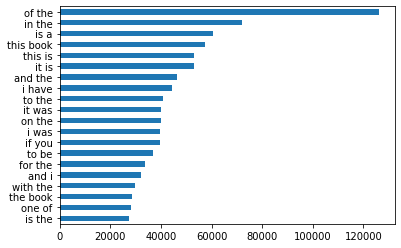

In [21]:
pd.Series(get_ngrams_from_series(df_train.content, 2)).value_counts()[:20][::-1].plot(kind='barh')

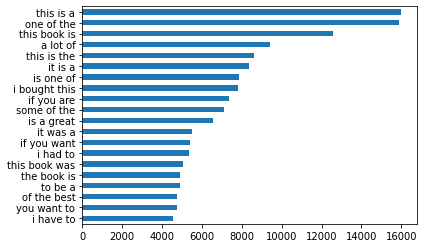

In [22]:
pd.Series(get_ngrams_from_series(df_train.content, 3)).value_counts()[:20][::-1].plot(kind='barh')

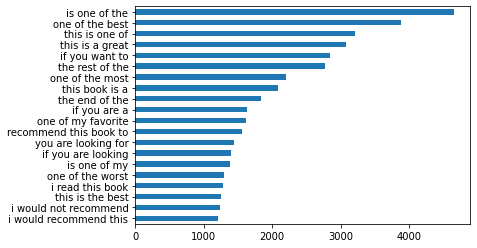

In [23]:
pd.Series(get_ngrams_from_series(df_train.content, 4)).value_counts()[:20][::-1].plot(kind='barh')

In [24]:
print(f'Number of non unique values in content: {len(df_train) - df_train["content"].nunique()}')

Number of non unique values in content: 214


### Content polarity

In [25]:
senti_analyze = sentiment.vader.SentimentIntensityAnalyzer()
df_train['sentiment_score'] = pd.DataFrame(df_train.content.apply(senti_analyze.polarity_scores).tolist())['compound']
df_train['sentiment'] = pd.cut(df_train['sentiment_score'], [-np.inf, -0.35, 0.35, np.inf], labels=['negative', 'neutral', 'positive'])

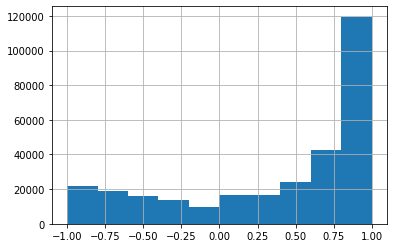

In [26]:
df_train.sentiment_score.hist()

In [27]:
full_text = ["--Comment Start--"]
for line in df_train['content']:
    full_text.append(line)
    full_text.append("--Comment End--")
    # full_text.append("")
    full_text.append("--Comment Start--")
    

with open('amazon_comments.txt', 'w') as filehandle:
    for listitem in full_text:
        filehandle.write('%s\n' % listitem)

### GPT-2 model

In [28]:
!nvidia-smi

Thu Jan 28 09:18:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple

TensorFlow 1.x selected.


In [2]:
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
gpt2.download_gpt2(model_name="355M")

Fetching checkpoint: 1.05Mit [00:00, 255Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 126Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 603Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:06, 236Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 534Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 119Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 171Mit/s]                                                       


In [4]:
gpt2.mount_gdrive()

Mounted at /content/drive


In [5]:
file_name = "amazon_comments.txt"
gpt2.copy_file_to_gdrive(file_name)

In [6]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              learning_rate=1e-4,
              dataset=file_name,
              model_name='355M',
              steps=2000,
              print_every=100,
              sample_every=1000,
              save_every=500)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Loading checkpoint models/355M/model.ckpt
INFO:tensorflow:Restoring parameters from models/355M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [02:32<00:00, 152.41s/it]


dataset has 31402403 tokens
Training...
[100 | 229.68] loss=2.87 avg=2.87
[200 | 453.32] loss=2.92 avg=2.89
[300 | 677.20] loss=2.97 avg=2.92
[400 | 901.16] loss=3.32 avg=3.02
[500 | 1125.23] loss=3.20 avg=3.06
Saving checkpoint/run1/model-500
[600 | 1360.47] loss=3.03 avg=3.05
[700 | 1584.73] loss=3.34 avg=3.09
[800 | 1809.06] loss=3.08 avg=3.09
[900 | 2033.29] loss=3.30 avg=3.12
[1000 | 2257.95] loss=3.18 avg=3.12
Saving checkpoint/run1/model-1000
Instructions for updating:
Use standard file APIs to delete files with this prefix.
======== SAMPLE 1 ========
 ordered to receive.I was looking for a more durable, solid design, and I would say this product does exactly what it was set up for. The front and rear handles were both good but that was not what i was looking for. The leather was soft, and the straps are a little difficult to take off after the first few uses, so I am very disappointed in this item.In all-around, this is a good item, but don't expect to find value in the price.


In [7]:
gpt2.generate(sess, length=350, temperature=0.9)

Comment Start
I bought this from a local store and was amazed at all the quality the piece had. I have many of my saturday morning counts all times so I bought this case to match with the laptop. Very easy to install and easy to clean as well.
--Comment End--
--Comment Start
This is a very good product and quite easy to use. PR could have used a few more watches
--Comment End--
--Comment Start
I bought this case for my MacBook Pro on a 16G. Everything I have had wasn't as great as expected -- some of the buttons didn't click by the center button. The usb cable doesn't work, too many buttons didn't click, and the keyboard didn't work as well as it should. I was completely dissatisfied with this product.
--Comment End--
--Comment Start
I am a big fan of Dell, so I ordered this when I got the Dell laptop, and by the time I had to return it (it was already returned), the case was broken in half, the other half was gone... This was the case for the Dell laptop. I am extremely disappointed i

In [8]:
gpt2.generate(sess, length=350, temperature=0.8)

Comment Start
1. I love this book. It is full of beautiful pictures of places and people. I would recommend it to anybody who is looking to get closer to their homeland.
--Comment End--
--Comment Start
Having spent much of my life in California, I am very glad to see that this wonderful book is available on Kindle in a full, colorful, easy to read format. I would recommend it to anyone who is looking to learn more about life in the U.S. from an original perspective.
--Comment End--
--Comment Start
This book was very disappointing...very poorly written, with a lot of redundant information. The only reason I even gave it a four-star rating is because I am a huge fan of the author, and I couldn't stand every page!
--Comment End--
--Comment Start
I will agree that the book is a very good way to learn more about life in the United States. Unfortunately, it is very much incomplete. There are some very good books out there that will help you learn more about life in the United States, but thi

## aitextgen

A robust tool for advanced AI text generation via GPT-2.

aitextgen is a Python package that leverages PyTorch, Huggingface Transformers and pytorch-lightning with specific optimizations for text generation using GPT-2, plus many added features

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install aitextgen

In [3]:
!pip install tokenizers==0.9.4

In [4]:
!pip install transformers==4.0.0

In [5]:
from aitextgen import aitextgen
from aitextgen.colab import mount_gdrive, copy_file_from_gdrive

In [6]:
!nvidia-smi

Thu Jan 28 11:02:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  75W |     10MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
ai = aitextgen(tf_gpt2="124M", to_gpu=True)

Converting TensorFlow checkpoint from /content/aitextgen/124M
Loading TF weight model/h0/attn/c_attn/b with shape [2304]
Loading TF weight model/h0/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h0/attn/c_proj/b with shape [768]
Loading TF weight model/h0/attn/c_proj/w with shape [1, 768, 768]
Loading TF weight model/h0/ln_1/b with shape [768]
Loading TF weight model/h0/ln_1/g with shape [768]
Loading TF weight model/h0/ln_2/b with shape [768]
Loading TF weight model/h0/ln_2/g with shape [768]
Loading TF weight model/h0/mlp/c_fc/b with shape [3072]
Loading TF weight model/h0/mlp/c_fc/w with shape [1, 768, 3072]
Loading TF weight model/h0/mlp/c_proj/b with shape [768]
Loading TF weight model/h0/mlp/c_proj/w with shape [1, 3072, 768]
Loading TF weight model/h1/attn/c_attn/b with shape [2304]
Loading TF weight model/h1/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h1/attn/c_proj/b with shape [768]
Loading TF weight model/h1/attn/c_proj/w with shape [1, 7

Save PyTorch model to aitextgen/pytorch_model.bin
Save configuration file to aitextgen/config.json


In [8]:
mount_gdrive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
file_name = "amazon_comments.txt"
copy_file_from_gdrive(file_name)

In [10]:
ai.train(file_name,
         line_by_line=False,
         from_cache=False,
         num_steps=2500,
         generate_every=500,
         save_every=500,
         save_gdrive=False,
         learning_rate=1e-4,
         batch_size=1, 
         )

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


500 steps reached: saving model to /trained_model
500 steps reached: generating sample texts.
--Comment Start--
This book was a good read of the history of the movie and the plot, but I didn't like it either. The plot was a little predictable. I found myself reading the book and it was just a good read. It's a good movie, but it just wasn't a great movie.
--Comment End--
--Comment Start--
This book was a great read. It was hard to read and I didn't like the "little girl" title. The characters were cute and I liked them all. I loved the story and it was a good read. I would recommend this book.
--Comment End--
--Comment Start--
I was so excited when I read the description for this movie. I loved it, it was a little funny, and it felt like a little boy was watching it.
--Comment End--
--Comment Start--
I'm sure that this is a very good movie. I was so excited when I saw the movie it made me really want to see the movie again. I just tried to not to spoil it. I can't wait for it to be ove

In [12]:
ai.generate()

--Comment Start--
Very nice, well-made, and has a nice selection of songs. It's a great album to listen to on a rainy afternoon.
--Comment End--
--Comment Start--
This is a great album. The songs are so sweet, it's easy to fall asleep and forget about it. The lyrics are great.
--Comment End--
--Comment Start--
I bought this CD and it was good, but the music is just not as good as what I saw in a record store. I felt like I was listening to some pretty good pop-up. The lyrics were just not as good. The songs, including "Stay Alive," "The Red Star" and "The Heart of the Music," are the best songs you'll ever listen to. This is a great album.
--Comment End--
--Comment Start--
I'm not sure what the title says but I can't stand this cd either. It's like a good album for the last 5 minutes. The only one I didn't like was "The Heart of the Music" and I really didn't like it either. I don't understand why everyone would consider this album to be such a good album. I hate to say it but


In [13]:
ai.generate(n=5,
            batch_size=5,
            max_length=256,
            temperature=0.9,
            top_p=0.9)

 (1) He had no problem with his songs on this album and was not the only bad song, the music really showed a lot of good songs, like "You're the One", "Letting Me Down", "Mama", and "Hey Jude", "A Boy, A Boy", "I've Got Love", "I've Got Love", "I'm Going Down", "You're the One", "Banger", "I'm Going Down" and "You're The One" were great songs. "Banger" was also an awesome song on this album. I would love to hear a great song on this album, but I will have to admit I have the only one that doesn't have the same thing as "I'm Going Down".
--Comment End--
--Comment Start--
I just got this CD and I'm not sure if it's the lyrics but it's pretty good. But, I'm not sure I can sing so much more, which i'm not like the other guys. But, I like the way the song "You're the One" is catchy to all of my friends. A must listen for anyone.
--Comment End--
--Comment Start--
If you like your songs and really
"The first time you see someone that is in their best shape, but not really an ordinary man. But